In [102]:
import pandas as pd
import numpy as np
import string
import nltk
import gensim
import wordcloud

from nltk import PorterStemmer
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [197]:
df = pd.read_csv('grantmaster.csv')
df.rename(columns={'Project title': 'Project_Title'}, inplace=True)
df = df.replace('nan', np.nan)
df = df.dropna()
df['log_CIHR_Contribution'] = df['log_CIHR_Contribution'].astype(int)
# Drop those rows
df = df[df['log_CIHR_Contribution'] != 0]
df['abstract_length'] = df['Abstract/Summary'].apply(lambda x: len(x.split()))
filtered_df = df[df['CIHR contribution'] <= 2500000]


removed_rows = df.shape[0] - filtered_df.shape[0]
print(f"Number of rows removed: {removed_rows}")
df = df[df['CIHR contribution'] <= 2500000]


Number of rows removed: 33


### Preprocessing the abstracts + cleaning data

In [206]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize

stop = set(stopwords.words('english'))
custom_remove_words = set([
    'applicable', 'for', 'and', 'nor', 'but', 'or', 'yet', 'so', 
    'after', 'although', 'because', 'before', 'if', 'until', 'when', 'while', 'where', 'as', 'though', 'unless', 'whether', 'however',
    'et', 'al', 'u', 'eg', 'ie', 'about', 'above', 'against', 'along', 'among', 'around', 'as', 'at', 'before', 'behind',
    'below', 'beneath', 'beside', 'between', 'beyond', 'by', 'despite', 'during', 'except', 'for', 'from',
    'in', 'inside', 'into', 'near', 'of', 'on', 'onto', 'opposite', 'out', 'outside', 'over', 'through', 
    'throughout', 'to', 'toward', 'under', 'underneath', 'until', 'upon', 'with', 'within', 'without', 'use', 'also'
])
stop.update(custom_remove_words)
punctuation = set(string.punctuation)
lemma = nltk.WordNetLemmatizer()

def clean(text):
    doc1 = text.lower()
    doc2 = doc1.split()
    doc3=[val for val in doc2 if val not in stop]
    doc4=" ".join([val for val in doc3]) 
    doc5=[val for val in doc4 if not val.isdigit()] #Exclude digits
    doc6="".join([val for val in doc5]) #compare to "".join(val for val in doc5)
    doc7=[val for val in doc6 if val not in punctuation]
    doc8="".join([val for val in doc7])
    doc9=doc8.split()
    doc10= [lemma.lemmatize(val) for val in doc9]
    doc11=" ".join([val for val in doc10])
    tokens = nltk.word_tokenize(doc11)
    return tokens

df['clean_abstr'] = df['Abstract/Summary'].apply(clean)
df['Combined_text'] = df['clean_abstr'].apply(lambda x: ' '.join(x))
clean_token = [token for tokens in df['clean_abstr'] for token in tokens]
df = df[df['clean_abstr'].apply(len) >= 5].reset_index(drop=True)
df['abstract_length'] = df['Abstract/Summary'].apply(len)
# One-hot encode the 'University' column
university_dummies = pd.get_dummies(df['Institution_Paid'], prefix='University', drop_first=True)

# Add dummy variables to the dataset
df = pd.concat([df, university_dummies], axis=1)


[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


### Finding bigrams

In [207]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel


### COllocation
abstracts = df['clean_abstr'].tolist()

##Finding bigrams
bigram = gensim.models.Phrases(df['clean_abstr'], min_count=5, threshold=10)
bigram_model = gensim.models.phrases.Phraser(bigram)
df['tokenized_bigrams'] = [bigram_model[doc] for doc in df['clean_abstr']]
df['Combined_bigram'] = df['tokenized_bigrams'].apply(lambda x: ' '.join(x))

### Creating a dictionary and bag of words corpus
dictionary = Dictionary(df['tokenized_bigrams'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in df['tokenized_bigrams']]


### Optimal number of topics + Coherence graph

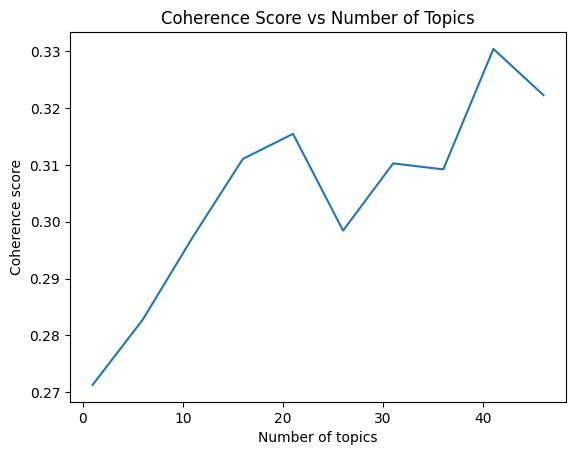

Optimal number of topics: 41
Topic 0: 0.059*"injury" + 0.021*"men" + 0.020*"sport" + 0.017*"injury_prevention" + 0.009*"canada" + 0.009*"risk" + 0.009*"alcohol" + 0.008*"canadian" + 0.007*"melanoma" + 0.007*"colombia"
Topic 1: 0.022*"community" + 0.018*"indigenous" + 0.016*"inuit" + 0.012*"project" + 0.007*"knowledge" + 0.006*"canada" + 0.006*"experience" + 0.005*"indigenous_people" + 0.005*"food_security" + 0.004*"food"
Topic 2: 0.012*"student" + 0.011*"community" + 0.009*"canada" + 0.007*"network" + 0.007*"support" + 0.006*"father" + 0.006*"housing" + 0.006*"training_platform" + 0.006*"steering_committee" + 0.006*"people_living"
Topic 3: 0.027*"youth" + 0.025*"community" + 0.013*"program" + 0.011*"indigenous" + 0.008*"care" + 0.007*"service" + 0.007*"experience" + 0.007*"need" + 0.006*"intervention" + 0.006*"project"
Topic 4: 0.012*"sa" + 0.011*"guideline_early" + 0.010*"family_caregiver" + 0.008*"drinking_water" + 0.008*"sb" + 0.008*"pwud" + 0.007*"phthalates" + 0.007*"breast_cancer

In [208]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns

topic_num = range(5, 50, 5)
coherence_score = []

### Evaluating coherence score for eahc number of topics
for num in topic_num:
    lda_model = LdaModel(corpus = bow_corpus, num_topics=num, id2word=dictionary,
                         random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=bow_corpus,
                                     texts=df['tokenized_bigrams'], dictionary=dictionary, coherence='c_v')
    coherence_score.append(coherence_model.get_coherence())

### Plotting the coherence scores
plt.plot(topic_num, coherence_score)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

### Choose the optimal number of topics
optimal_topics = topic_num[coherence_score.index(max(coherence_score))]
print('Optimal number of topics:', optimal_topics)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")



### LDA + Heatmap of the topics

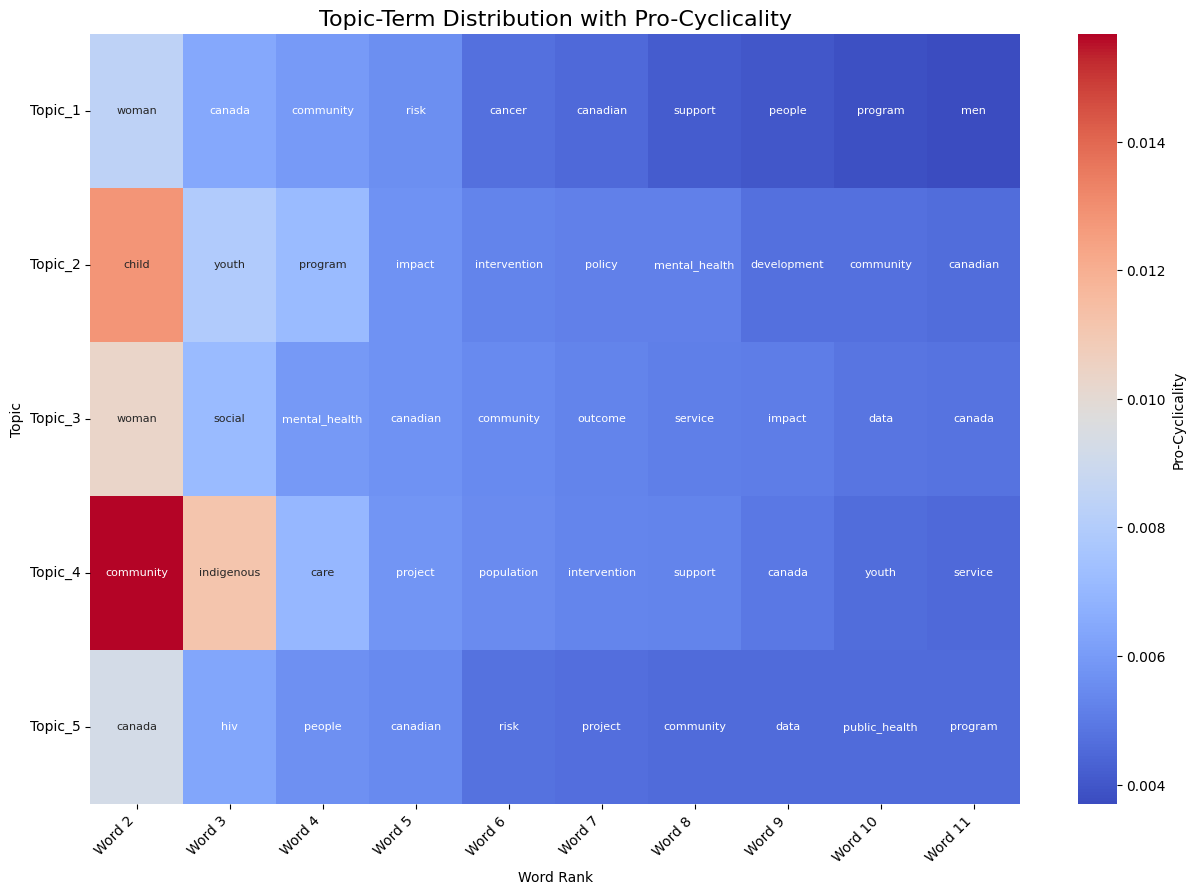

In [186]:
num_top = 5
### LDA modeling
lda_model = LdaModel(bow_corpus, num_topics=num_top, id2word=dictionary, random_state=42)
topic_distributions = [dict(lda_model.get_document_topics(bow)) for bow in bow_corpus]
topic_df = pd.DataFrame.from_records(topic_distributions).fillna(0)
topic_df.columns = [f"Topic_{i+1}" for i in range(num_top)]
topic_df.index = df.index
topic_df = topic_df.sort_index()

df = df.sort_index()
topic_df['Grant_Amount'] = df['log_CIHR_Contribution']
topic_df = pd.concat([topic_df, university_dummies], axis=1)
topic_df['Term_Years'] = df['Term_Years']
topic_df['Year'] = df['Year']
topic_df['abstract_length'] = df['abstract_length']

### Categorizing the grant amount

bins = [4, 9, 11, 12, 14, 16]
labels = ['Very Small', 'Small', 'Moderate', 'Large', 'Very Large']

# Categorize Grant_Amount
topic_df['funding_category'] = pd.cut(
    topic_df['Grant_Amount'], bins=bins, labels=labels, include_lowest=True
)

category_order = {"Very Small": 1, "Small": 2, "Moderate": 3, "Large": 4, "Very Large": 5}
topic_df['funding_category'] = topic_df['funding_category'].map(category_order)



################# Creating the Heatmap ####################
num_words = 10  # Number of top words to display per topic
topics = []
probabilities = []
for i in range(lda_model.num_topics):
    top_words = lda_model.show_topic(i, topn=num_words)
    topics.append([word for word, prob in top_words])
    probabilities.append([prob for word, prob in top_words])

# Create a DataFrame for topic words
topic_words_df = pd.DataFrame(topics, columns=[f"Word_{i+1}" for i in range(num_words)])
topic_words_df.index = [f"Topic_{i+1}" for i in range(lda_model.num_topics)]

# Step 2: Add Pro-Cyclicality or an alternative metric
# Example: Using the sum of probabilities as a simple "Pro-Cyclicality" measure
topic_words_df['Pro-Cyclicality'] = [sum(prob) for prob in probabilities]

# Step 3: Prepare Data for Heatmap
heatmap_data = pd.DataFrame(probabilities, index=topic_words_df.index, columns=[f"Word {i+1}" for i in range(1, num_words+1)])

# Step 4: Create Heatmap with Improved Word Placement
plt.figure(figsize=(15, 10))  # Increase figure size for better readability

# Create heatmap with color for "Pro-Cyclicality"
sns.heatmap(
    heatmap_data, 
    cmap='coolwarm',    # Colormap for better contrast
    annot=topics,       # Annotate with topic words
    fmt='',             # Disable numerical formatting in annotations
    annot_kws={"size": 8},  # Reduce font size of words
    cbar_kws={'label': 'Pro-Cyclicality'}  # Add color bar label
)

# Add labels and title
plt.xlabel('Word Rank')
plt.ylabel('Topic')
plt.title('Topic-Term Distribution with Pro-Cyclicality', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()


### Wordcloud

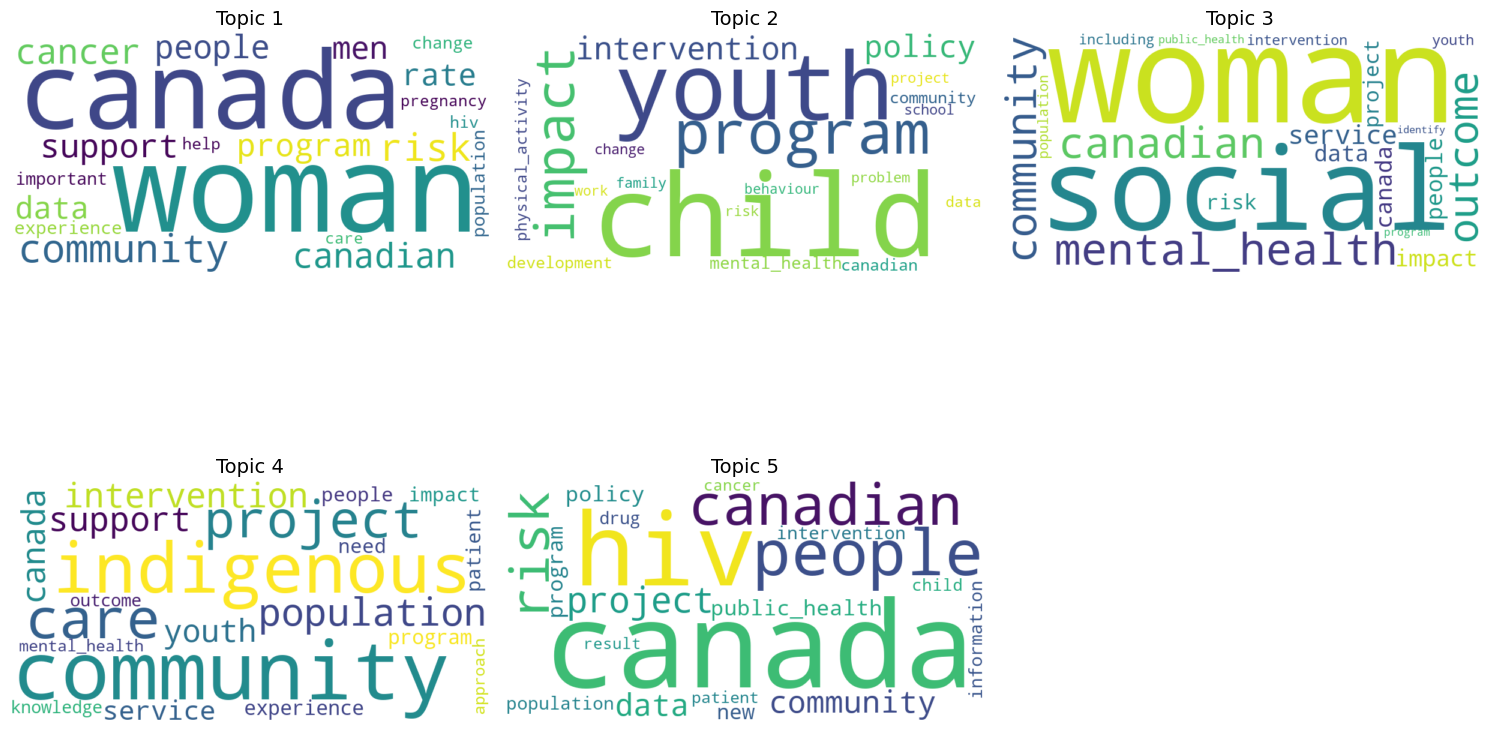

In [187]:
from wordcloud import WordCloud

# Define function to generate a word cloud for a single topic
def generate_wordcloud(lda_model, topic_id, num_words=20):
    """Generate a word cloud for a specific topic."""
    # Extract top words and their probabilities
    top_words = lda_model.show_topic(topic_id, topn=num_words)
    word_freqs = {word: prob for word, prob in top_words}
    
    # Create the word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color='white'
    ).generate_from_frequencies(word_freqs)
    
    return wordcloud

# Generate and plot word clouds for all topics
num_topics = lda_model.num_topics
plt.figure(figsize=(15, 10))

for topic_id in range(num_topics):
    # Generate word cloud for the current topic
    wordcloud = generate_wordcloud(lda_model, topic_id)
    
    # Plot the word cloud
    plt.subplot(2, (num_topics + 1) // 2, topic_id + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id+1}", fontsize=14)

plt.tight_layout()
plt.show()

## Classifier

In [160]:
x = topic_df.drop(['funding_category', 'Grant_Amount'], axis = 1)
y = topic_df['funding_category']
X_train, X_test, y_train, y_test = train_test_split(x, y,  test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Apply scaling to relevant features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [139]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


results = {}
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
knn_model = KNeighborsClassifier()
lda_model = LinearDiscriminantAnalysis()
def train_and_evaluate(model, param_grid=None):
    if param_grid:  # Perform grid search if param_grid is provided
        if model in (logistic_model, knn_model, lda_model):
            grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
        else:
            grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)
    
    if model in (logistic_model, knn_model, lda_model):
        cv_score = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        print(f"Cross-validation accuracy: {cv_score:.4f}")
    # Cross-validation score
    else:
        cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()
        print(f"Cross-validation accuracy: {cv_score:.4f}")
        
    # Evaluate on test data
    if model in (logistic_model, knn_model, lda_model):
        y_pred = best_model.predict(X_test_scaled)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
    else:
        y_pred = best_model.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        
    return best_model, cv_score

# 1. Multinomial Logistic Regression
print("\n1. Multinomial Logistic Regression")
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
logistic_param_grid = {'C': [0.1, 1, 10]}  # Regularization parameter
results['Logistic Regression'] = train_and_evaluate(logistic_model, logistic_param_grid)

# 2. Decision Tree
print("\n2. Decision Tree")
tree_model = DecisionTreeClassifier(random_state=42)
tree_param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
results['Decision Tree'] = train_and_evaluate(tree_model, tree_param_grid)

# 3. Random Forest
print("\n3. Random Forest")
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]}
results['Random Forest'] = train_and_evaluate(rf_model, rf_param_grid)

# 4. Gradient Boosting
print("\n4. Gradient Boosting")
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
results['Gradient Boosting'] = train_and_evaluate(gb_model, gb_param_grid)

# 5. Naive Bayes
print("\n5. Naive Bayes")
nb_model = MultinomialNB()
nb_param_grid = {'alpha': [0.1, 1, 10]}  # Smoothing parameter
results['Naive Bayes'] = train_and_evaluate(nb_model, nb_param_grid)

# 6. k-Nearest Neighbors (k-NN)
print("\n6. k-Nearest Neighbors (k-NN)")
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
results['k-NN'] = train_and_evaluate(knn_model, knn_param_grid)

# 7. Linear Discriminant Analysis (LDA)
print("\n7. Linear Discriminant Analysis")
lda_model = LinearDiscriminantAnalysis()
lda_param_grid = None  # No hyperparameters to tune for LDA
results['LDA'] = train_and_evaluate(lda_model, lda_param_grid)

# Summary of cross-validation scores
print("\nSummary of Cross-Validation Scores:")
for model_name, (model, score) in results.items():
    print(f"{model_name}: {score:.4f}")


1. Multinomial Logistic Regression


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

Best parameters: {'C': 0.1}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Pytho

Cross-validation accuracy: 0.5005
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.48      0.53       287
           2       0.48      0.64      0.55       472
           3       0.30      0.16      0.20       174
           4       0.41      0.35      0.38       161
           5       0.00      0.00      0.00         3

    accuracy                           0.48      1097
   macro avg       0.35      0.32      0.33      1097
weighted avg       0.47      0.48      0.46      1097

Confusion Matrix:
[[137 148   2   0   0]
 [ 94 304  34  40   0]
 [  2 105  27  40   0]
 [  0  77  28  56   0]
 [  0   2   0   1   0]]

2. Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Cross-validation accuracy: 0.5401
Classification Report:
              precision    recall  f1-score   support

           1       0.65      0.80      0.71       287
           2       0.53      0.52      0.53       472
           3       0.3

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Best parameters: {'max_depth': 20, 'n_estimators': 100}
Cross-validation accuracy: 0.5625
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.67      0.68       287
           2       0.52      0.75      0.61       472
           3       0.50      0.11      0.19       174
           4       0.59      0.30      0.40       161
           5       0.00      0.00      0.00         3

    accuracy                           0.56      1097
   macro avg       0.46      0.37      0.37      1097
weighted avg       0.56      0.56      0.53      1097

Confusion Matrix:
[[193  94   0   0   0]
 [ 90 356   8  18   0]
 [  1 138  20  15   0]
 [  0 101  12  48   0]
 [  0   2   0   1   0]]

4. Gradient Boosting


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Cross-validation accuracy: 0.5602
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.80      0.71       287
           2       0.53      0.67      0.59       472
           3       0.37      0.06      0.11       174
           4       0.54      0.40      0.46       161
           5       0.00      0.00      0.00         3

    accuracy                           0.56      1097
   macro avg       0.42      0.39      0.37      1097
weighted avg       0.53      0.56      0.53      1097

Confusion Matrix:
[[230  57   0   0   0]
 [126 314   8  24   0]
 [  1 133  11  29   0]
 [  0  86  11  64   0]
 [  0   2   0   1   0]]

5. Naive Bayes


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Best parameters: {'alpha': 10}
Cross-validation accuracy: 0.2782
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.41      0.37       287
           2       0.41      0.14      0.21       472
           3       0.00      0.00      0.00       174
           4       0.19      0.68      0.30       161
           5       0.00      0.00      0.00         3

    accuracy                           0.27      1097
   macro avg       0.19      0.25      0.18      1097
weighted avg       0.29      0.27      0.23      1097

Confusion Matrix:
[[117  56   0 114   0]
 [146  68   0 257   1]
 [ 48  26   0 100   0]
 [ 34  17   0 110   0]
 [  0   0   0   3   0]]

6. k-Nearest Neighbors (k-NN)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Best parameters: {'n_neighbors': 10, 'weights': 'distance'}
Cross-validation accuracy: 0.4774
Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.52      0.54       287
           2       0.49      0.65      0.56       472
           3       0.35      0.20      0.26       174
           4       0.42      0.28      0.33       161
           5       0.00      0.00      0.00         3

    accuracy                           0.49      1097
   macro avg       0.36      0.33      0.34      1097
weighted avg       0.47      0.49      0.47      1097

Confusion Matrix:
[[148 128   6   5   0]
 [100 307  34  31   0]
 [ 10 103  35  26   0]
 [  7  85  24  45   0]
 [  0   2   0   1   0]]

7. Linear Discriminant Analysis


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Cross-validation accuracy: 0.2873
Classification Report:
              precision    recall  f1-score   support

           1       0.29      0.89      0.44       287
           2       0.00      0.00      0.00       472
           3       0.12      0.01      0.01       174
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00         3

    accuracy                           0.23      1097
   macro avg       0.08      0.18      0.09      1097
weighted avg       0.10      0.23      0.12      1097

Confusion Matrix:
[[254   0   2   0  31]
 [374   0   4   0  94]
 [118   0   1   1  54]
 [124   0   1   0  36]
 [  3   0   0   0   0]]

Summary of Cross-Validation Scores:
Logistic Regression: 0.5005
Decision Tree: 0.5401
Random Forest: 0.5625
Gradient Boosting: 0.5602
Naive Bayes: 0.2782
k-NN: 0.4774
LDA: 0.2873


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/py

## Regression

In [189]:
x = topic_df.drop(['Grant_Amount', 'funding_category'], axis = 1)
y = topic_df['Grant_Amount']
X_train, X_test, y_train, y_test = train_test_split(x, y,  test_size=0.2, random_state=42)


### Novelty Score

In [209]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Compute novelty scores for training data
similarity_matrix_train = cosine_similarity(X_train)
average_similarity_train = (similarity_matrix_train.sum(axis=1) - 1) / (similarity_matrix_train.shape[0] - 1)
novelty_scores_train = 1 - average_similarity_train
novelty_scores_train = np.log1p(novelty_scores_train)

# Compute novelty scores for test data
similarity_matrix_test = cosine_similarity(X_test, X_train)
average_similarity_test = similarity_matrix_test.mean(axis=1)
novelty_scores_test = 1 - average_similarity_test
novelty_scores_test = np.log1p(novelty_scores_test)

# Normalize novelty scores
scaler = MinMaxScaler()
novelty_scores_train = scaler.fit_transform(novelty_scores_train.reshape(-1, 1))
novelty_scores_test = scaler.transform(novelty_scores_test.reshape(-1, 1))

### Model Tuning + Evaluations

In [210]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()
X_train_combined = np.hstack([X_train, novelty_scores_train])
X_test_combined = np.hstack([X_test, novelty_scores_test])
# Apply scaling to relevant features
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)
results = {}

def evaluate_model(model, model_name, use_scaled=True):
    """Train and evaluate a model. Choose scaled or unscaled data based on the model type."""
    if use_scaled:
        model.fit(X_train_scaled, y_train)  # Train on scaled data
        y_pred = model.predict(X_test_scaled)  # Predict on scaled data
    else:
        model.fit(X_train_combined, y_train)  # Train on unscaled data
        y_pred = model.predict(X_test_combined)  # Predict on unscaled data

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}")
    results[model_name] = {'model': model, 'mse': mse, 'r2': r2}

# Function to train and evaluate models
def evaluate_model(model, model_name, use_scaled=True):
    """Train and evaluate a model. Choose scaled or unscaled data based on the model type."""
    if use_scaled:
        model.fit(X_train_scaled, y_train)  # Train on scaled data
        y_pred = model.predict(X_test_scaled)  # Predict on scaled data
    else:
        model.fit(X_train_combined, y_train)  # Train on unscaled data
        y_pred = model.predict(X_test_combined)  # Predict on unscaled data

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}")
    results[model_name] = {'model': model, 'mse': mse, 'r2': r2}

# 1. Linear Regression
evaluate_model(LinearRegression(), "Linear Regression", use_scaled=True)

# 2. Ridge Regression
ridge_model = Ridge()
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)
best_ridge_model = ridge_grid.best_estimator_
print(f"Best parameters: {ridge_grid.best_params_}")
evaluate_model(best_ridge_model, "Ridge Regression", use_scaled=True)

# 3. Lasso Regression
lasso_model = Lasso(max_iter=5000)
lasso_params = {'alpha': [0.01, 0.1, 1.0]}
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, y_train)
best_lasso_model = lasso_grid.best_estimator_
print(f"Best parameters: {lasso_grid.best_params_}")
evaluate_model(best_lasso_model, "Lasso Regression", use_scaled=True)

# Define the Elastic Net model
elastic_net = ElasticNet(max_iter=5000, random_state=42)

# Hyperparameter tuning
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]  # Balance between L1 and L2
}

grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression models
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)
best_elastic_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
evaluate_model(best_elastic_model, "Elastic Net", use_scaled=True)

# 4. Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_params = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
tree_grid = GridSearchCV(tree_model, tree_params, cv=5, scoring='neg_mean_squared_error')
tree_grid.fit(X_train_combined, y_train)  # No scaling needed for trees
best_tree_model = tree_grid.best_estimator_
print(f"Best parameters: {tree_grid.best_params_}")
evaluate_model(best_tree_model, "Decision Tree", use_scaled=False)

# 5. Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_combined, y_train)
best_rf_model = rf_grid.best_estimator_
print(f"Best parameters: {rf_grid.best_params_}")
evaluate_model(best_rf_model, "Random Forest", use_scaled=False)

# 6. Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gb_grid = GridSearchCV(gb_model, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train_combined, y_train)
best_gb_model = gb_grid.best_estimator_
print(f"Best parameters: {gb_grid.best_params_}")
evaluate_model(best_gb_model, "Gradient Boosting", use_scaled=False)

# 7. k-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()
knn_params = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
knn_grid = GridSearchCV(knn_model, knn_params, cv=5, scoring='neg_mean_squared_error')
knn_grid.fit(X_train_scaled, y_train)
best_knn_model = knn_grid.best_estimator_
print(f"Best parameters: {knn_grid.best_params_}")
evaluate_model(best_knn_model, "k-NN", use_scaled=True)

# Summary of Results
print("\nSummary of Results:")
summary = pd.DataFrame.from_dict(results, orient='index')
print(summary[['mse', 'r2']])

Linear Regression - MSE: 53824274817875162693632.0000, R²: -15915281815102367465472.0000
Best parameters: {'alpha': 0.1}
Ridge Regression - MSE: 1.8840, R²: 0.4429
Best parameters: {'alpha': 0.01}
Lasso Regression - MSE: 1.8644, R²: 0.4487
Best parameters: {'alpha': 0.01, 'l1_ratio': 1}
Elastic Net - MSE: 1.8644, R²: 0.4487
Best parameters: {'max_depth': 5, 'min_samples_split': 5}
Decision Tree - MSE: 1.5837, R²: 0.5317
Best parameters: {'max_depth': 10, 'n_estimators': 200}
Random Forest - MSE: 1.4918, R²: 0.5589
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Gradient Boosting - MSE: 1.4905, R²: 0.5593
Best parameters: {'n_neighbors': 10, 'weights': 'distance'}
k-NN - MSE: 2.2897, R²: 0.3230

Summary of Results:
                            mse            r2
Linear Regression  5.382427e+22 -1.591528e+22
Ridge Regression   1.883998e+00  4.429211e-01
Lasso Regression   1.864442e+00  4.487039e-01
Elastic Net        1.864442e+00  4.487039e-01
Decision Tree    

### Plots showing the correlation between the topics and grant amount


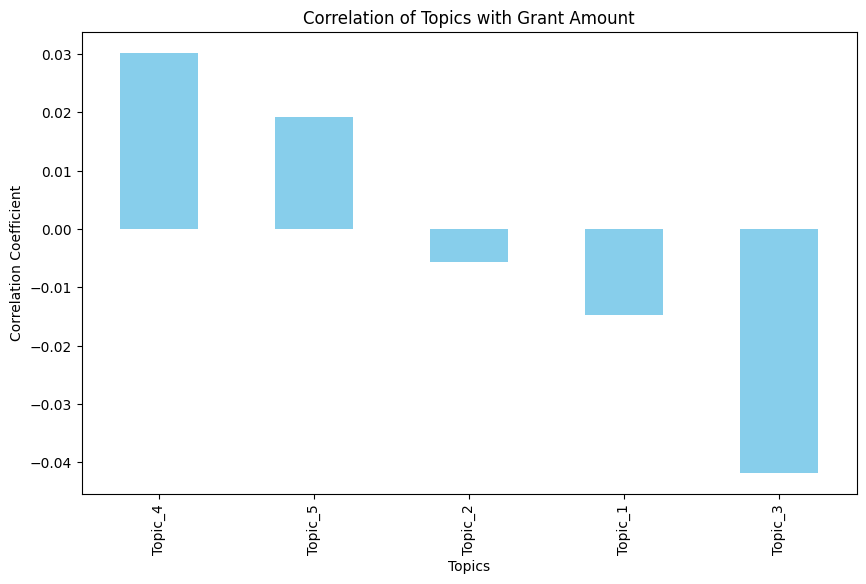

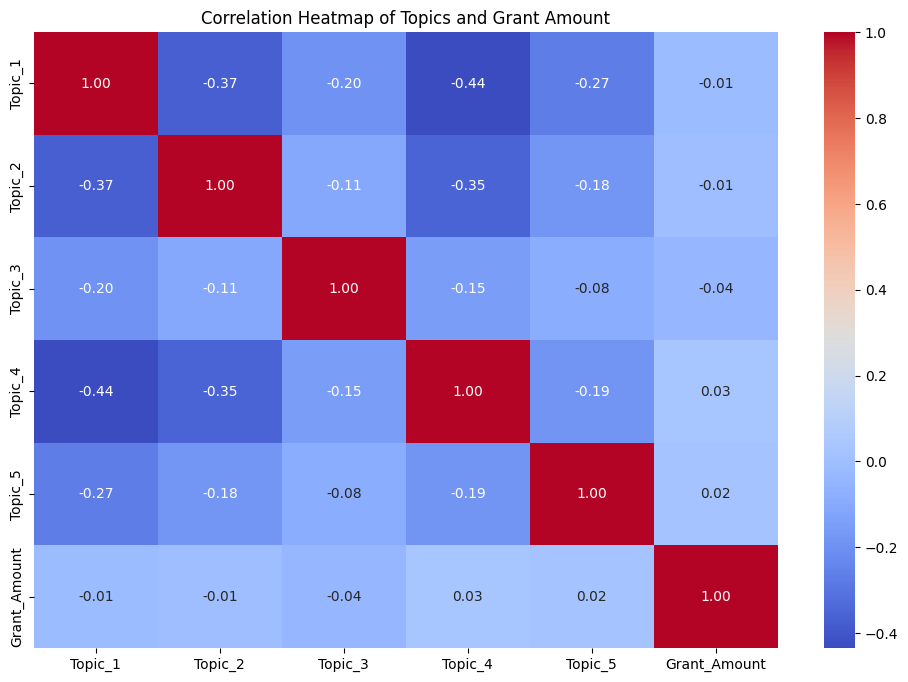

ValueError: could not convert string to float: 'Topic_1'

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify topic columns (assumes topic columns are named 'Topic_1', 'Topic_2', ...)
topics = [col for col in topic_df.columns if col.startswith('Topic_')]

# Calculate correlation between topics and grant amount
correlation_matrix = topic_df[topics + ['Grant_Amount']].corr()
topic_corr = correlation_matrix['Grant_Amount'].drop('Grant_Amount')

# Visualize as a bar chart
plt.figure(figsize=(10, 6))
topic_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Correlation of Topics with Grant Amount")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Topics")
plt.show()


plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)
plt.title("Correlation Heatmap of Topics and Grant Amount")
plt.show()

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Train Random Forest Regressor
rf_model = GradientBoostingRegressor(random_state=42)
rf_model.fit(topic_df, topic_df['Grant_Amount'])

# Feature Importance
feature_importance = pd.DataFrame({
    'Topic': topics,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Topic', data=feature_importance, palette='viridis')
plt.title("Topic Importance for Predicting Grant Amount")
plt.show()


/var/folders/hm/xlv0j4yj57d8wljr_lg_1jth0000gn/T/ipykernel_7554/2916229787.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=topic_df, x='Dominant_Topic', y='Grant_Amount', palette='coolwarm')


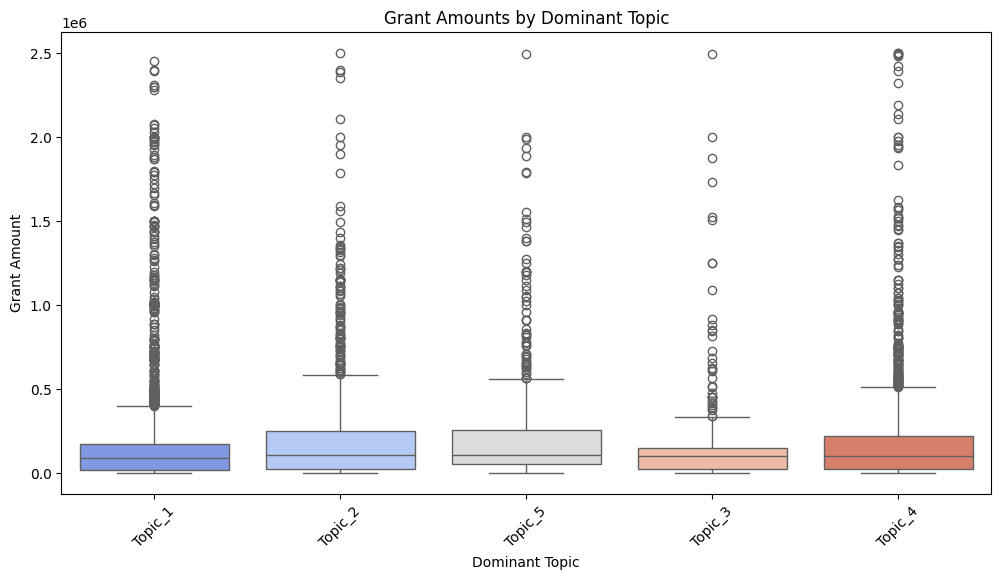

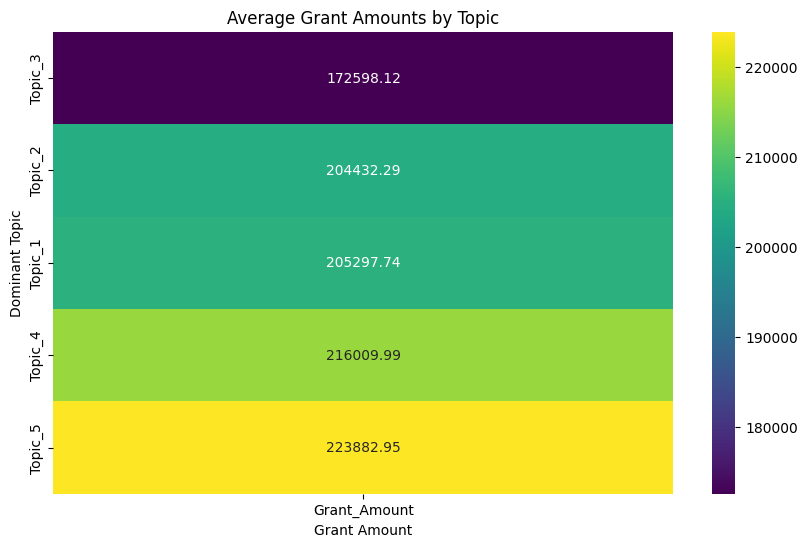

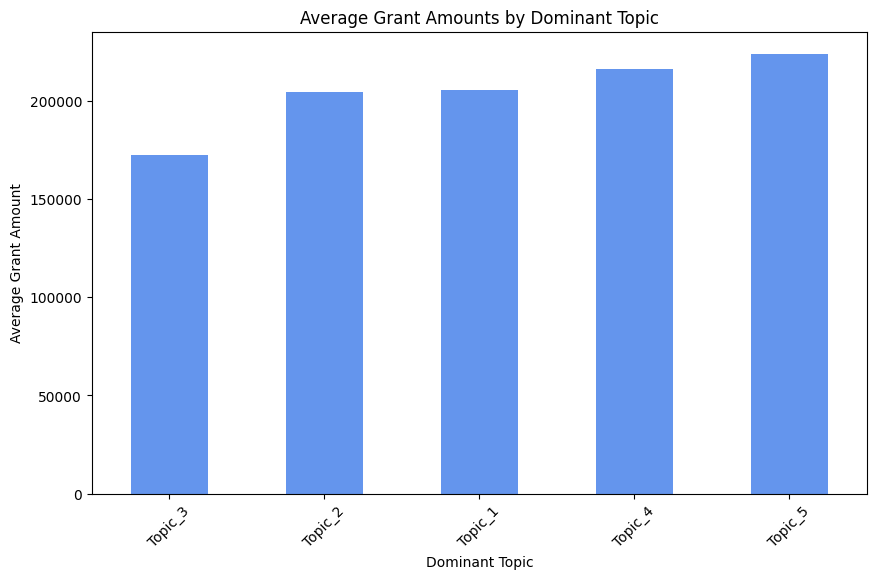

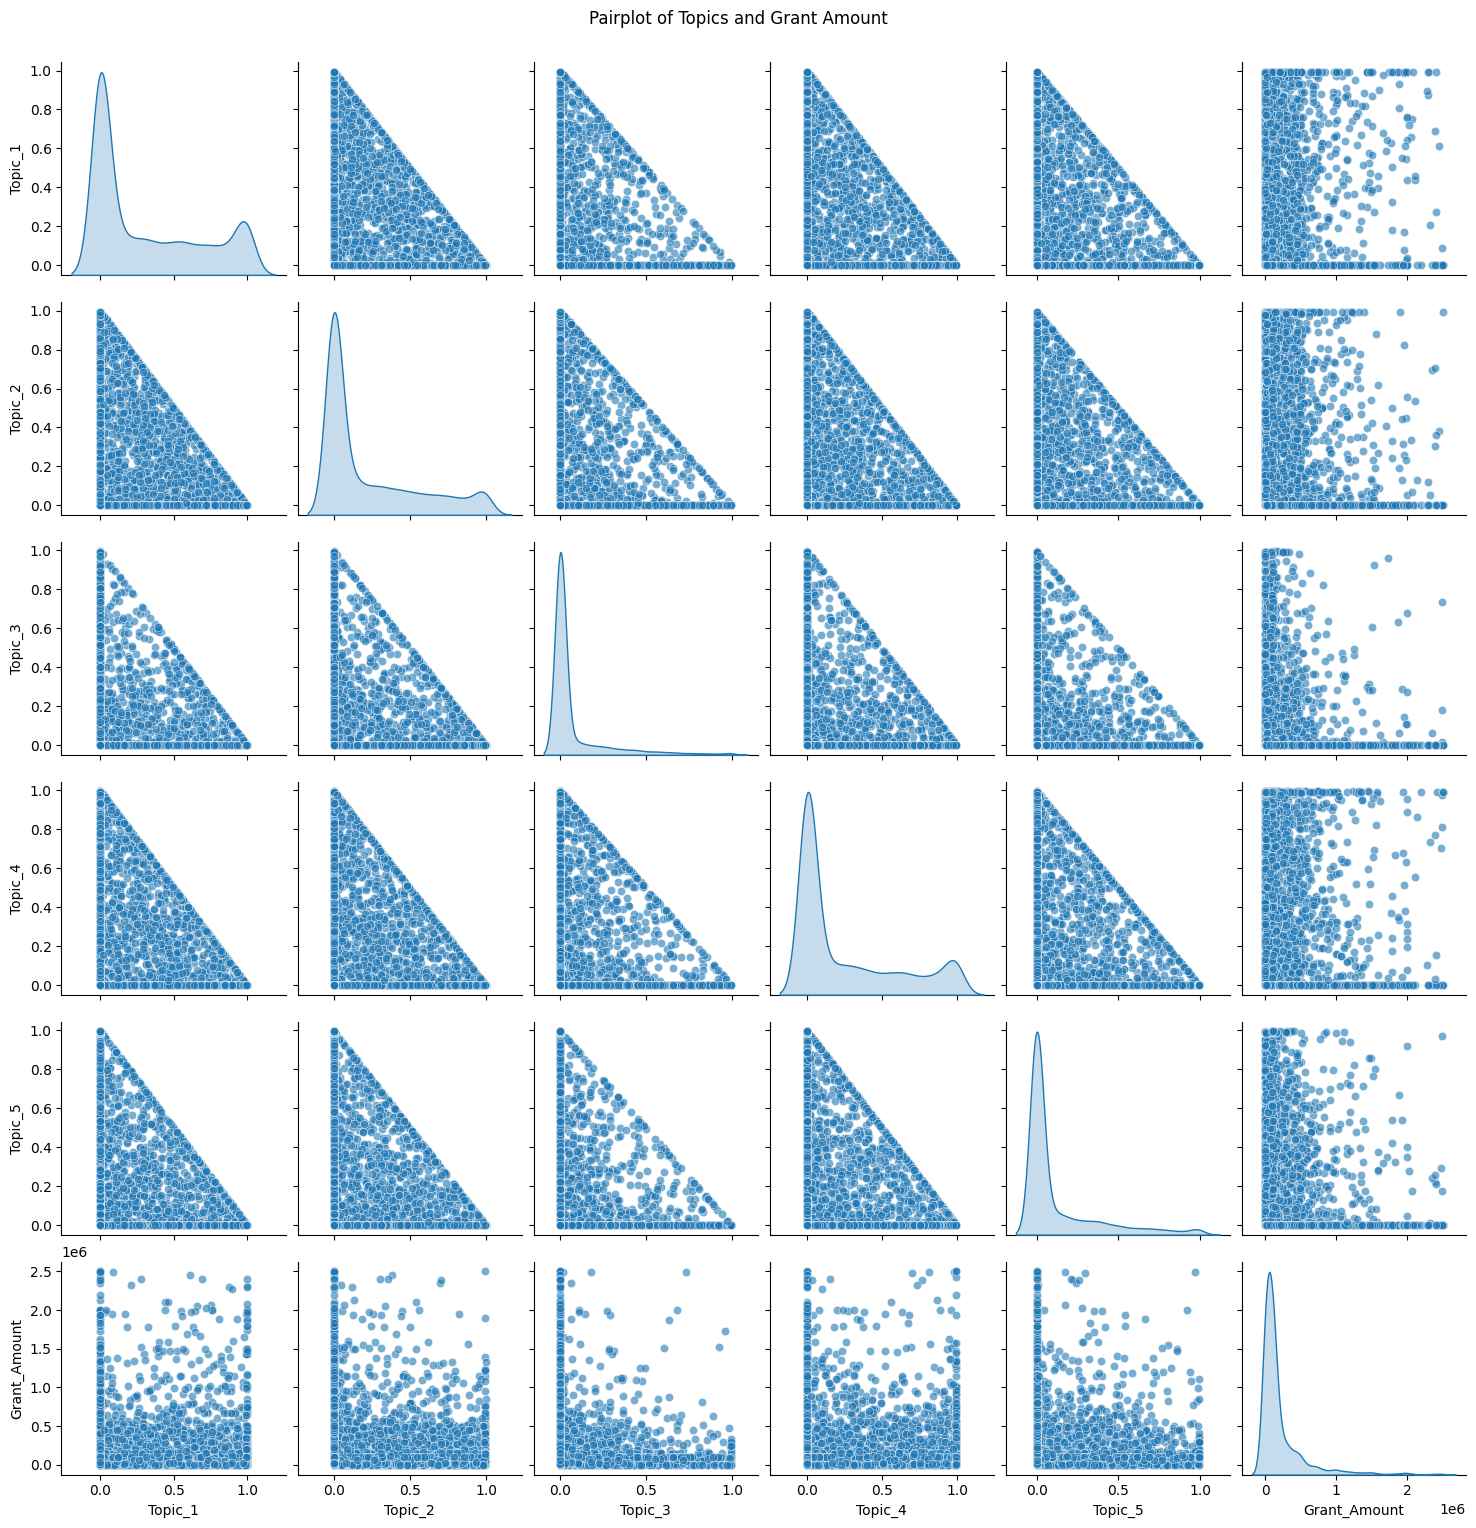

/var/folders/hm/xlv0j4yj57d8wljr_lg_1jth0000gn/T/ipykernel_7554/2916229787.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=topic_df, x='Dominant_Topic', y='Grant_Amount', palette='muted', scale='width')
/var/folders/hm/xlv0j4yj57d8wljr_lg_1jth0000gn/T/ipykernel_7554/2916229787.py:41: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=topic_df, x='Dominant_Topic', y='Grant_Amount', palette='muted', scale='width')


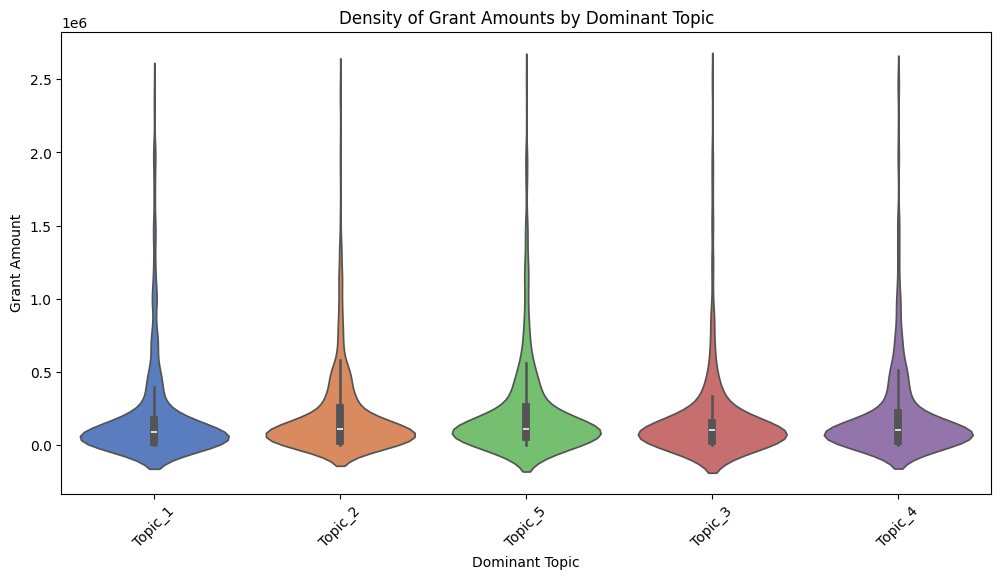

In [194]:
topic_df['Dominant_Topic'] = topic_df[[col for col in topic_df.columns if col.startswith('Topic_')]].idxmax(axis=1)
topic_df['Grant_Amount'] = df['CIHR contribution']
# Boxplot: Grant Amount distribution for each dominant topic
plt.figure(figsize=(12, 6))
sns.boxplot(data=topic_df, x='Dominant_Topic', y='Grant_Amount', palette='coolwarm')
plt.title("Grant Amounts by Dominant Topic")
plt.ylabel("Grant Amount")
plt.xlabel("Dominant Topic")
plt.xticks(rotation=45)
plt.show()

# Calculate average grant amounts for each dominant topic
avg_grants_by_topic = topic_df.groupby('Dominant_Topic')['Grant_Amount'].mean().sort_values()

# Heatmap: Average grant amounts by topic
plt.figure(figsize=(10, 6))
sns.heatmap(avg_grants_by_topic.to_frame(), annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Average Grant Amounts by Topic")
plt.ylabel("Dominant Topic")
plt.xlabel("Grant Amount")
plt.show()

# Bar chart: Average grant amount by dominant topic
avg_grants_by_topic = topic_df.groupby('Dominant_Topic')['Grant_Amount'].mean()

plt.figure(figsize=(10, 6))
avg_grants_by_topic.sort_values().plot(kind='bar', color='cornflowerblue')
plt.title("Average Grant Amounts by Dominant Topic")
plt.ylabel("Average Grant Amount")
plt.xlabel("Dominant Topic")
plt.xticks(rotation=45)
plt.show()
# Pairplot for all topics and Grant Amount
topic_columns = [col for col in topic_df.columns if col.startswith('Topic_')]

sns.pairplot(topic_df[topic_columns + ['Grant_Amount']], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Topics and Grant Amount", y=1.02)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=topic_df, x='Dominant_Topic', y='Grant_Amount', palette='muted', scale='width')
plt.title("Density of Grant Amounts by Dominant Topic")
plt.ylabel("Grant Amount")
plt.xlabel("Dominant Topic")
plt.xticks(rotation=45)
plt.show()
